# Project 7: Neural Network
Duncan Muir

In [38]:
import sklearn.datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from nn import nn, io, preprocess
import optuna

## Part 1: Autoencoder 

### Read in Digits Dataset

In [2]:
digits = sklearn.datasets.load_digits()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=.1, random_state=14)

In [4]:
X_train.shape, X_test.shape

((1617, 64), (180, 64))

### Hyperparameter Search w/ Optuna

In [31]:
def objective(trial):
    encode_activ_func = trial.suggest_categorical("encode_activ_func",["relu", "sigmoid"]) 
    decode_activ_func = trial.suggest_categorical("decode_activ_func",["relu", "sigmoid"]) 
    learning_rate = trial.suggest_int("learning_rate", -7, -1, 1)  # learning rate
    batch_size = trial.suggest_categorical('batch_size', [10, 50, 100, 200, 400])
    n_epochs = trial.suggest_categorical('n_epochs', [10, 100, 500, 1000])
    
    trial_net = nn.NeuralNetwork(
        nn_arch = [{'input_dim': 64, 'output_dim': 16, 'activation': encode_activ_func},
                   {'input_dim': 16, 'output_dim': 64, 'activation': decode_activ_func}],
        lr = 1 * np.exp(learning_rate),
        rand=np.random.RandomState(27),
        batch_size=batch_size,
        epochs=n_epochs,
        loss_function="mse")
    train_losses, val_losses = trial_net.fit(X_train, X_train, X_test, X_test)
    
    return val_losses[-1]

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

[I 2022-03-05 20:03:02,855] A new study created in memory with name: no-name-df4bf0b1-ddda-48ed-8261-b1acbc1fadb6
[I 2022-03-05 20:03:11,279] Trial 0 finished with value: 10.754584269226202 and parameters: {'encode_activ_func': 'relu', 'decode_activ_func': 'relu', 'learning_rate': -7, 'batch_size': 10, 'n_epochs': 500}. Best is trial 0 with value: 10.754584269226202.
[I 2022-03-05 20:03:11,473] Trial 1 finished with value: 11.502041237368783 and parameters: {'encode_activ_func': 'relu', 'decode_activ_func': 'relu', 'learning_rate': -5, 'batch_size': 10, 'n_epochs': 10}. Best is trial 0 with value: 10.754584269226202.
[I 2022-03-05 20:03:14,007] Trial 2 finished with value: 50.188448233939894 and parameters: {'encode_activ_func': 'sigmoid', 'decode_activ_func': 'sigmoid', 'learning_rate': -4, 'batch_size': 200, 'n_epochs': 500}. Best is trial 0 with value: 10.754584269226202.
[I 2022-03-05 20:03:14,216] Trial 3 finished with value: 31.761450391294865 and parameters: {'encode_activ_func'

In [32]:
study.best_params

{'encode_activ_func': 'relu',
 'decode_activ_func': 'relu',
 'learning_rate': -4,
 'batch_size': 100,
 'n_epochs': 1000}

### Construct Autoencoder

In [33]:
net = nn.NeuralNetwork(
    nn_arch = [{'input_dim': 64, 'output_dim': 16, 'activation': 'relu'},
               {'input_dim': 16, 'output_dim': 64, 'activation': 'relu'}],
    lr = np.exp(-4),
    rand = np.random.RandomState(27),
    batch_size=100,
    epochs=1000,
    loss_function="mse")

### Train Autoencoder

In [34]:
train_losses, val_losses = net.fit(X_train, X_train, X_test, X_test)

### Plot Trian and Val Loss

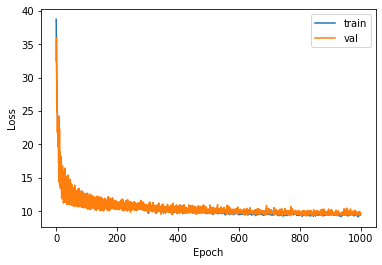

In [36]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

### Reconstruction Error on Test Set

In [39]:
mean_squared_error(net.predict(X_test), X_test)

9.544779607151284

### Show Reconstructred Example Image

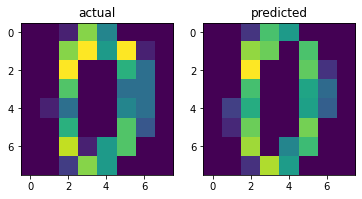

In [37]:
fig, (ax1, ax2) = plt.subplots(1,2)
pred = net.predict(digits.data[0])
ax1.imshow(digits.data[0].reshape(8,8), vmin=4)
ax1.set_title("actual")
ax2.set_title("predicted")
ax2.imshow(pred.reshape(8,8), vmin=4)

## Part 2: Transcription Factor Classifier

### Read in Data

In [40]:
positives = io.read_text_file("./data/rap1-lieb-positives.txt")
negatives = io.read_fasta_file("./data/yeast-upstream-1k-negative.fa")

### Sample 17-bp seq from negatives to match positive seq lengths

In [41]:
pos_length = len(positives[0])

negs_shortened = []
for seq in negatives:
    negs = [seq[i*pos_length:(i + 1)*pos_length] for i in range(len(seq) // pos_length)]
    negs_shortened.extend(negs)
neg_seqs = list(np.array(negs_shortened)[np.random.randint(len(negs_shortened), size=10000)])

In [42]:
all_seqs = positives + neg_seqs
all_labels = [True] * len(positives) + [False] * len(neg_seqs)

### Over-Sample From Positive to Generate Balanced Dataset
I decided to use an over-sampling scheme here as an under-sampling scheme would result in an insufficiently sized dataset.

In [43]:
balanced_seqs, balanced_labels = preprocess.sample_seqs(all_seqs, all_labels)

In [44]:
pos_balanced = list(np.array(balanced_seqs)[balanced_labels])
neg_balanced = list(np.array(balanced_seqs)[[not label for label in balanced_labels]])

### One-Hot Encode Sequence Data

In [45]:
one_hot_pos = preprocess.one_hot_encode_seqs(pos_balanced)
one_hot_neg = preprocess.one_hot_encode_seqs(neg_balanced)

In [46]:
pos_with_labels = np.hstack((one_hot_pos, np.ones((one_hot_pos.shape[0], 1))))
neg_with_labels = np.hstack((one_hot_neg, np.zeros((one_hot_neg.shape[0], 1))))

### Generate Dataset

In [47]:
dataset = np.concatenate([pos_with_labels, neg_with_labels], axis=0)

In [48]:
dataset.shape

(20000, 69)

In [49]:
X_train_tfc, X_test_tfc, y_train_tfc, y_test_tfc = train_test_split(dataset[:,:-1], dataset[:,-1][:, np.newaxis], test_size=.1, random_state=27)

In [50]:
X_train_tfc.shape

(18000, 68)

### Hyperparameter Search w/ Optuna

In [57]:
def tcf_objective(trial):
    hidden_activ_func = trial.suggest_categorical("hidden_activ_func",["relu", "sigmoid"]) 
    learning_rate = trial.suggest_int("learning_rate", -7, -1, 1)  # learning rate
    batch_size = trial.suggest_categorical('batch_size', [10, 50, 100, 200, 400])
    n_epochs = trial.suggest_categorical('n_epochs', [10, 100, 500, 1000])
    n_neurons = trial.suggest_int('n_neurons', 10, 100, 10)
    
    trial_clf = nn.NeuralNetwork(
        nn_arch = [{'input_dim': 68, 'output_dim': n_neurons, 'activation': hidden_activ_func},
                   {'input_dim': n_neurons, 'output_dim': 1, 'activation': 'sigmoid'}],
        lr = 1 * np.exp(learning_rate),
        rand=np.random.RandomState(27),
        batch_size=batch_size,
        epochs=n_epochs,
        loss_function="bce")
    
    tcf_train_losses, tcf_val_losses = trial_clf.fit(X_train_tfc, y_train_tfc, X_test_tfc, y_test_tfc)
    
    return tcf_val_losses[-1]

tcf_study = optuna.create_study(direction="minimize")
tcf_study.optimize(tcf_objective, n_trials=15)

[I 2022-03-05 20:24:52,771] A new study created in memory with name: no-name-25e6b82f-8a68-42c6-9017-542a949bf880
[I 2022-03-05 20:24:54,680] Trial 0 finished with value: 0.03236317704373623 and parameters: {'hidden_activ_func': 'relu', 'learning_rate': -7, 'batch_size': 10, 'n_epochs': 10, 'n_neurons': 30}. Best is trial 0 with value: 0.03236317704373623.
/Users/duncanmuir/ucsf_biophysics/bmi-203/project7/nn/nn.py:399: RuntimeWarning: divide by zero encountered in log
  total_loss = -(y.T.dot(np.log(y_hat)) + (1 - y.T).dot(np.log(1 - y_hat))).item()
[I 2022-03-05 20:25:21,895] Trial 1 finished with value: 0.004858318616961323 and parameters: {'hidden_activ_func': 'relu', 'learning_rate': -1, 'batch_size': 50, 'n_epochs': 500, 'n_neurons': 60}. Best is trial 1 with value: 0.004858318616961323.
[I 2022-03-05 20:27:26,693] Trial 2 finished with value: 0.005081588151048866 and parameters: {'hidden_activ_func': 'sigmoid', 'learning_rate': -3, 'batch_size': 10, 'n_epochs': 500, 'n_neurons':

In [58]:
tcf_study.best_params

{'hidden_activ_func': 'relu',
 'learning_rate': -1,
 'batch_size': 50,
 'n_epochs': 500,
 'n_neurons': 60}

### Construct Classifier
Binary cross entropy loss is used in this context due to the classification nature of the problem, as the BCE function will penalized predictions that have lower probablilities of being their correct class.

In [60]:
clf = nn.NeuralNetwork(
    nn_arch = [{'input_dim': 68, 'output_dim': 60, 'activation': 'relu'},
               {'input_dim': 60, 'output_dim': 1, 'activation': 'sigmoid'}],
    lr = 1e-1,
    rand=np.random.RandomState(27),
    batch_size=50,
    epochs=500,
    loss_function="bce")

### Train Classifier

In [61]:
train_losses_tfc, val_losses_tfc = clf.fit(X_train_tfc, y_train_tfc, X_test_tfc, y_test_tfc)

### Plot Train and Validation Loss

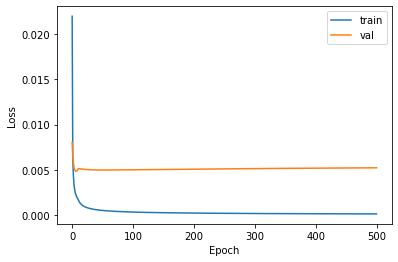

In [62]:
plt.plot(train_losses_tfc, label="train")
plt.plot(val_losses_tfc, label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

### Testing / Validation Accuracy

In [63]:
accuracy_score((clf.predict(X_test_tfc) >= .5).astype(int), y_test_tfc)

0.999